In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded=files.upload()

Saving ratings.csv to ratings.csv
Saving movies.csv to movies.csv


In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [4]:
df_r=pd.read_csv('ratings.csv')
df_r

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [5]:
df_m=pd.read_csv('movies.csv')
df_m

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [6]:
df=pd.merge(df_r, df_m, on='movieId', how='left')
df

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
...,...,...,...,...,...,...
99999,671,6268,2.5,1065579370,Raising Victor Vargas (2002),Comedy|Drama|Romance
100000,671,6269,4.0,1065149201,Stevie (2002),Documentary
100001,671,6365,4.0,1070940363,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
100002,671,6385,2.5,1070979663,Whale Rider (2002),Drama


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  100004 non-null  int64  
 1   rating  100004 non-null  float64
 2   title   100004 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ MB


In [9]:
df=df.drop(['movieId', 'timestamp', 'genres'], axis=1)

In [11]:
df=df.set_index('userId')
df

,rating,title
userId,,
1,2.5,Dangerous Minds (1995)
1,3.0,Dumbo (1941)
1,3.0,Sleepers (1996)
1,2.0,Escape from New York (1981)
1,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989)
...,...,...
671,2.5,Raising Victor Vargas (2002)
671,4.0,Stevie (2002)
671,4.0,"Matrix Reloaded, The (2003)"


In [13]:
df.groupby('title')['rating'].mean().head()

title
"Great Performances" Cats (1998)           1.750000
$9.99 (2008)                               3.833333
'Hellboy': The Seeds of Creation (2004)    2.000000
'Neath the Arizona Skies (1934)            0.500000
'Round Midnight (1986)                     2.250000
Name: rating, dtype: float64

In [14]:
df.groupby(['title'])['rating'].mean().sort_values(ascending=False)

title
Ivan Vasilievich: Back to the Future (Ivan Vasilievich menyaet professiyu) (1973)    5.0
Alien Escape (1995)                                                                  5.0
Boiling Point (1993)                                                                 5.0
Bone Tomahawk (2015)                                                                 5.0
Borgman (2013)                                                                       5.0
                                                                                    ... 
Waterloo Bridge (1940)                                                               0.5
Karla (2006)                                                                         0.5
Ring of Terror (1962)                                                                0.5
Road Games (a.k.a. Roadgames) (1981)                                                 0.5
Beastmaster 2: Through the Portal of Time (1991)                                     0.5
Name: rating, L

In [15]:
df.groupby(['title'])['rating'].count().sort_values(ascending=False)

title
Forrest Gump (1994)                                   341
Pulp Fiction (1994)                                   324
Shawshank Redemption, The (1994)                      311
Silence of the Lambs, The (1991)                      304
Star Wars: Episode IV - A New Hope (1977)             291
                                                     ... 
Robin Williams: Weapons of Self Destruction (2009)      1
Good German, The (2006)                                 1
Good Earth, The (1937)                                  1
Robot Overlords (2014)                                  1
İtirazım Var (2014)                                     1
Name: rating, Length: 9064, dtype: int64

In [16]:
user_title_matrix = pd.crosstab(df.index,df.title)
user_title_matrix

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
row_0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df[df['title']=='(500) Days of Summer (2009)']

,rating,title
userId,,
13,4.0,(500) Days of Summer (2009)
48,4.5,(500) Days of Summer (2009)
69,5.0,(500) Days of Summer (2009)
73,4.5,(500) Days of Summer (2009)
78,4.0,(500) Days of Summer (2009)
81,2.0,(500) Days of Summer (2009)
132,4.5,(500) Days of Summer (2009)
133,4.5,(500) Days of Summer (2009)
149,3.0,(500) Days of Summer (2009)


In [18]:
df_check = df[['title','rating']]
df_check

,title,rating
userId,,
1,Dangerous Minds (1995),2.5
1,Dumbo (1941),3.0
1,Sleepers (1996),3.0
1,Escape from New York (1981),2.0
1,Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.0
...,...,...
671,Raising Victor Vargas (2002),2.5
671,Stevie (2002),4.0
671,"Matrix Reloaded, The (2003)",4.0


In [19]:
pd.crosstab(df_check.index,df_check.title, values = df_check.rating,aggfunc='mean')

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
row_0,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_c=pd.DataFrame(df.groupby(['title', 'userId'])['rating'].mean())
df_c.T

title  "Great Performances" Cats (1998)      $9.99 (2008)            \
userId                              207  557          132  468  488   
rating                              0.5  3.0          4.5  2.5  4.5   

title  'Hellboy': The Seeds of Creation (2004)  \
userId                                     134   
rating                                     2.0   

title  'Neath the Arizona Skies (1934) 'Round Midnight (1986)       \
userId                             207                    207  547   
rating                             0.5                    0.5  4.0   

title  'Salem's Lot (2004)  ... ¡Three Amigos! (1986)                      \
userId                 134  ...                   575  580  581  621  624   
rating                 3.5  ...                   3.0  3.5  3.5  3.5  3.0   

title                 À nous la liberté (Freedom for Us) (1931)  \
userId  638  646  654                                       481   
rating  4.5  4.0  4.5                                       4.5   

title  İtirazım Var (2014)  
userId                 270  
rating                 3.5  

[1 rows x 100003 columns]

In [ ]:
#df_c['rating_count'] = pd.DataFrame(df.groupby(['userId', 'movieId'])['rating'].count())
#df_c

rating  rating_count
userId movieId                      
1      1           4.0             1
       3           4.0             1
       6           4.0             1
       47          5.0             1
       50          5.0             1
...                ...           ...
610    166534      4.0             1
       168248      5.0             1
       168250      5.0             1
       168252      5.0             1
       170875      3.0             1

[100836 rows x 2 columns]

In [ ]:
#df_c=np.where(df_mean_count > 3)
#df_c

(array([   0,    1,    2, ..., 9711, 9714, 9717]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
#df_rat=pd.merge(df, df1, on='movieId')
#df_rat

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [ ]:
#df=pd.DataFrame(df,columns=df.movieId)
#df

In [ ]:
df.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
df.shape

(100836, 4)

In [ ]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
df_rat.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
imputer=SimpleImputer(strategy='constant', fill_value=2)

In [23]:
df_d=imputer.fit_transform(df_c)
df_d

array([[0.5],
       [3. ],
       [4.5],
       ...,
       [4.5],
       [4.5],
       [3.5]])

## Create a  Model

In [24]:
from sklearn.decomposition import NMF

In [25]:
model = NMF(n_components=3, max_iter=200)

In [26]:
model.fit(df_d)

NMF(n_components=3)

# Defining P and Q

In [27]:
q=model.components_
q

array([[0.33871721],
       [0.26740914],
       [1.8367951 ]])

In [28]:
q_df=pd.DataFrame(model.components_, columns=df_c.columns, index=['feature1', 'feature2', 'feature3'])
q_df

,rating
feature1,0.338717
feature2,0.267409
feature3,1.836795


In [29]:
import seaborn as sns

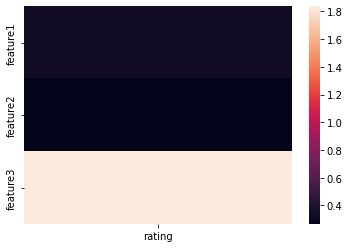

In [30]:
sns.heatmap(q_df)

In [31]:
p=model.transform(df_d)
p

array([[1.47615764e+00, 0.00000000e+00, 0.00000000e+00],
       [8.85694586e+00, 4.40210364e-15, 0.00000000e+00],
       [1.32854188e+01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.32854188e+01, 0.00000000e+00, 0.00000000e+00],
       [1.32854188e+01, 0.00000000e+00, 0.00000000e+00],
       [1.03331035e+01, 3.10518677e-15, 0.00000000e+00]])

In [32]:
p_df=pd.DataFrame(p, columns=['feature1', 'feature2', 'feature3'], index=df_c.index)
p_df

feature1      feature2  \
title                                     userId                            
"Great Performances" Cats (1998)          207      1.476158  0.000000e+00   
                                          557      8.856946  4.402104e-15   
$9.99 (2008)                              132     13.285419  0.000000e+00   
                                          468      7.380788  0.000000e+00   
                                          488     13.285419  0.000000e+00   
...                                                     ...           ...   
¡Three Amigos! (1986)                     638     13.285419  0.000000e+00   
                                          646     11.809261  0.000000e+00   
                                          654     13.285419  0.000000e+00   
À nous la liberté (Freedom for Us) (1931) 481     13.285419  0.000000e+00   
İtirazım Var (2014)                       270     10.333104  3.105187e-15   

                                                  feature3  
title                                     userId            
"Great Performances" Cats (1998)          207          0.0  
                                          557          0.0  
$9.99 (2008)                              132          0.0  
                                          468          0.0  
                                          488          0.0  
...                                                    ...  
¡Three Amigos! (1986)                     638          0.0  
                                          646          0.0  
                                          654          0.0  
À nous la liberté (Freedom for Us) (1931) 481          0.0  
İtirazım Var (2014)                       270          0.0  

[100003 rows x 3 columns]

In [ ]:
sns.heatmap(p_df, annot=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f59d3aed9e0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
model.reconstruction_err_

0.3011698778325314

In [ ]:
r=pd.DataFrame(np.dot(p,q).round(), index=df_c.index, columns=df_c.columns)
r

,rating,rating_count
title,,
'71 (2014),4.0,1.0
'Hellboy': The Seeds of Creation (2004),4.0,1.0
'Round Midnight (1986),3.0,2.0
'Salem's Lot (2004),5.0,1.0
'Til There Was You (1997),4.0,2.0
...,...,...
eXistenZ (1999),4.0,22.0
xXx (2002),3.0,24.0
xXx: State of the Union (2005),2.0,5.0


In [ ]:
df_c.columns

Index(['rating', 'rating_count'], dtype='object')

# **Get New Ratings**

In [ ]:
model.transform(df)

array([[1547.08820934,    0.        ],
       [1547.08587504,    0.        ],
       [1547.08744139,    0.        ],
       ...,
       [2395.66181379,   40.39116223],
       [2394.97772401,   40.3916468 ],
       [2394.97782502,   41.02157383]])

In [ ]:
df.columns

AttributeError: ignored